In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import subprocess

import sys
from copy import copy
import scipy
import imageio
sys.path.append("../")
import itertools
from scipy.stats import norm
import matplotlib.mlab as mlab
from mvgavg import mvgavg
import json
import matplotlib.patches as mpatches
from matplotlib import gridspec
import matplotlib.patches as mpatch

from matplotlib.ticker import FormatStrFormatter


save_folder = "G:/DREAM/from_github/thesis/Figures/LDA/"
import seaborn as sns

from random import randrange
from joblib import wrap_non_picklable_objects


from alienlab import utils
import alienlab
from alienlab import regression_func
import pickle as pk
from alienlab import plot
from activation_experiment import activation_experiment


import skimage.registration


from useful_func import dtw, get_path, plot_warped_timeseries
from useful_func import spectrum_a, spectrum_d
from useful_func import residuals, exp_decay, get_fit, sigmoid, exp_decay_max
from useful_func import gradient_magnitude, gradient_orientation, gaussian_kernel, assign_orientation, crop_center, cconv, get_algae_im
from numpy import genfromtxt

from joblib import Parallel, delayed
from useful_func import make_svm, make_pca
from sklearn.decomposition import PCA

from mpl_toolkits.axes_grid1 import make_axes_locatable



import sklearn
import sklearn.discriminant_analysis
import pandas as pd


import skimage

from useful_func import fit_biexp, fit_exp, fit_monoexp

import tifffile as tiff
import random
import matplotlib
%matplotlib widget


import alienlab.plot
p = alienlab.plot.PlotFigure()
p.extension = ".pdf"
p.date = False
p.figsize = (10,10)
p.fonttick=12
p.fontsize=18
p.save_folder = "G:/DREAM/from_github/Single_cell_paper/Figures/"

In [2]:
data_folder = "plotly_data/"


traces_list = np.load(data_folder + 'traces_list.npy') # pulses
pulses = np.load(data_folder + 'pulses_list.npy')
Z = {}
method_list = ['combine0', 'combine1', 'combine2', 'combine3', "pulses"]
for method in method_list:
    Z[method] = np.load(data_folder + method + "_array_proj.npy") # projections des dictionnaires 3D résultat LDA
    
label_list = np.load(data_folder + 'label_list.npy')
algae_list = np.load(data_folder + 'algae_list.npy')
imref_list = np.load(data_folder + 'imref_list.npy')
mask_list = np.load(data_folder + 'mask_list.npy')
time_list = np.load(data_folder + 'time_list.npy')
time_list -= time_list[:,0:1]
time_pulses = time_list[:,250::20]

class_match = json.load(open(data_folder + "class_match.json"))
colmap = json.load(open(data_folder + "color_map.json"))# colormap 
colmap = {int(k):v for k,v in colmap.items()}
id_list = np.load(data_folder + 'id_list.npy')
exp_array = np.load(data_folder + 'exp_list.npy')

lims = {}
for method in method_list:
    lims[method] = json.load(open(data_folder + method + "_array_ax_lim.json"))

    
TEI = ["qT", "qE", "qI"]

In [3]:
def cmap_from_ext(low, high, N):
    cvals  = [0,  1]
    colors = [low, high]

    norm=plt.Normalize(min(cvals),max(cvals))
    tuples = list(zip(map(norm,cvals), colors))
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)
    cmap = cmap(np.linspace(0, 1, N+N//3))[N//3:N]
    random.seed(4)
    random.shuffle(cmap)
    im = np.linspace(0, N-1, N).astype(int)
    plt.figure()
    u = np.tile(cmap[:,:3], (1, 1, 1))
    print(u.shape)
    plt.imshow(u)
    plt.axis('off')
    return cmap



def generate_col(N): #colormap
    color_condition = {}
    
    color_condition["0_0_0"] = cmap_from_ext("lavender", "mediumslateblue", N)
    
    color_condition["0_0_3"] = cmap_from_ext("lightblue", "cornflowerblue", N)
    color_condition["0_0_3"] = cmap_from_ext("royalblue", "mediumblue", N)
    
    color_condition["0_1_3"] = cmap_from_ext("bisque", "darkorange", N)
    color_condition["0_1_2"] = cmap_from_ext("moccasin", "orange", N)

    color_condition["1_0_2"] = cmap_from_ext("mediumseagreen", "green", N)
    color_condition["1_0_3"] = cmap_from_ext("palegreen", "forestgreen", N)
    
    color_condition["1_1_2"] = cmap_from_ext("indianred", "brown", N)
    color_condition["1_1_3"] = cmap_from_ext("mistyrose", "tomato", N)
    
    return color_condition



In [4]:
def cmap_from_plt(cmap, N):
    cmap = matplotlib.colormaps[cmap]
    start = N//2
    cmap = cmap(np.linspace(0, 1, N+start))
    cmap = cmap[start:]
    random.seed(4)
    random.shuffle(cmap)
    #plt.figure()
    #u = np.tile(cmap[:,:3], (1, 1, 1))
    #plt.imshow(u)
    #plt.axis('off')
    return cmap

def generate_col(N): #colormap
    color_condition = {}
    
    color_condition["0_0_0"] = cmap_from_plt("Purples", N)

    color_condition["1_0_0"] = cmap_from_plt("Greys", N)

        
    color_condition["0_0_2"] = cmap_from_plt("Blues", N)
    color_condition["0_0_3"] = cmap_from_plt("Blues", N)
    
    color_condition["0_1_3"] = cmap_from_plt("Oranges", N)
    color_condition["0_1_2"] = cmap_from_plt("Oranges", N)

    color_condition["1_0_2"] = cmap_from_plt("Greens", N)
    color_condition["1_0_3"] = cmap_from_plt("Greens", N)
    
    color_condition["1_1_2"] = cmap_from_plt("Reds", N)
    color_condition["1_1_3"] = cmap_from_plt("Reds", N)
    
    color_condition["2_0_2"] = cmap_from_plt("Oranges", N)
    color_condition["2_0_3"] = cmap_from_plt("Oranges", N)
    
    color_condition["3_0_2"] = cmap_from_plt("terrain", N)
    color_condition["3_0_3"] = cmap_from_plt("terrain", N)
    
    return color_condition

def get_idxs(id_list, sel_classes): #select experiment
    idxs = []
    for i,c in enumerate(sel_classes):  
      nidxs=np.where(id_list==c)[0]
      idxs=np.concatenate([idxs,nidxs])
    return idxs

def create_fig(data, method, x, y, color_condition, fig, markersize = 2):
    X0 = traces_list[data]
    Z0 = Z[method][data]
    label_list0 = label_list[data]
    id_list0 = id_list[data]
    algae_list0 = algae_list[data]

    class_color = np.zeros((len(label_list0),4)).astype(str)
    for i, c in enumerate(np.unique(label_list0)):
        pos = label_list0 == c
        class_color[label_list0 == c] = color_condition[c][id_list0[pos]%10]
    plt.scatter(x = Z0[:,x], y = Z0[:,y], c=class_color, s= markersize)#id_list0.astype(str))#, color_discrete_sequence=colmap)
    plt.xlim(lims[method]["%d,%d"%(x,y)][0])
    plt.ylim(lims[method]["%d,%d"%(x,y)][1])
    plt.xlabel(TEI[x])
    plt.ylabel(TEI[y])
    plt.legend()

    return fig

def define_idxs(selected, method):
    idxs = get_idxs(id_list, np.array(selected).astype(int))
    idxs = np.array(idxs, dtype=int)
    Z0 = Z[method][idxs]
    select = np.zeros(idxs.shape)
    for val in np.unique(id_list[idxs]):
        mask = id_list[idxs]==val
        zcrop = abs(Z0 - np.mean(Z0[mask], axis = 0)) < 2.5 * np.std(Z0[mask], axis = 0)
        zcrop = zcrop.min(axis = 1)   
        prod = mask*zcrop
        print(val, np.sum(prod)/np.sum(mask)*100, '% kept')
        select += prod
    select = select.astype(bool)
    idxs = idxs[select]
    return idxs

In [10]:
purple = [0, 162, 182, 198, 365]#, 162, 182, 198] #0_0_0
            
blue = [1, 2, 367]#[2, 3] #165, 185, 201, #0_0_3
            
orange = [6, 120, 168, 188, 204, #0_1_2
            7, 121, 169, 189, 205] #0_1_3
            
green = [14, 57, 251,#1_0_2
            15, 252,] #1_0_3
            #229, 239, 228, 238, 36, 46, 35, 45,
    
grey = [12, 55, 249]#1_0_0

red = [19]

wt4_activation = [57, 60, 61, 64, 65, 68, 69] #chunck activation

cc124_activation = [257, 260, 261, 264]
cc124_activation_13 = [268, 272, 275, 280]

wt4_inhibition = [249, 250, 251, 252]
wt4_inhibition2 = [12, 13, 14, 15]


method = "combine0"
x = 0 #qT
y = 1 #qE

## Illumination protocol

In [11]:
#headers, data = alienlab.utils.pandas_to_arrays("plotly_data/example_output_plot.csv")
#for i, h in enumerate(headers):
#    print(i, h)
#plt.figure()
#blue = np.copy(data[6])
#blue[data[5]>1190] = 0
#plt.plot(data[5], blue/5)
#plt.plot(data[9], data[10], color = "mediumpurple")


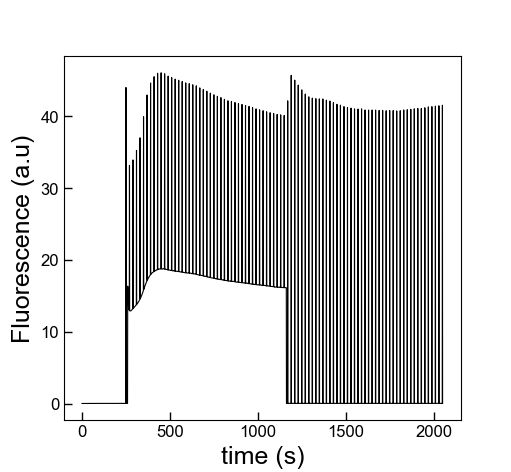

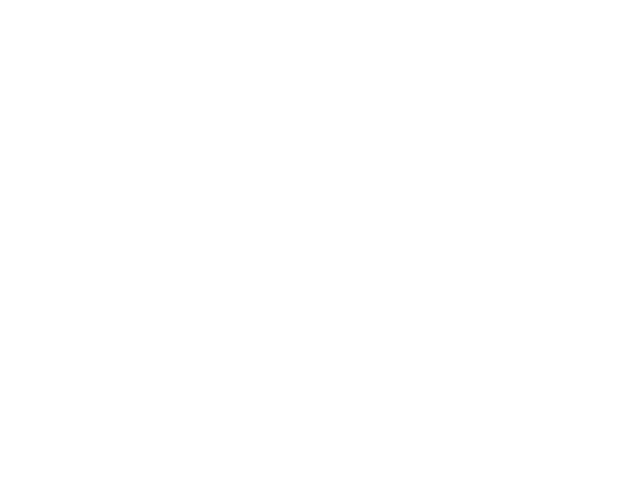

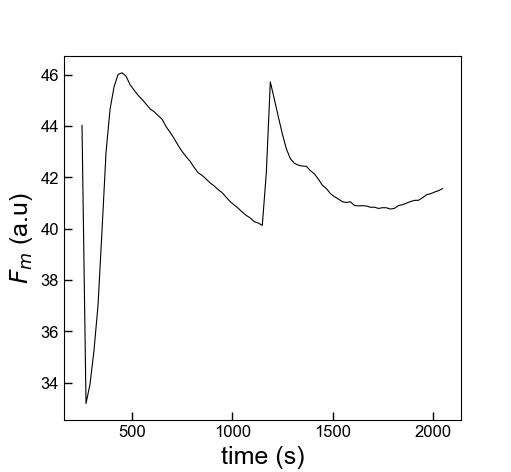

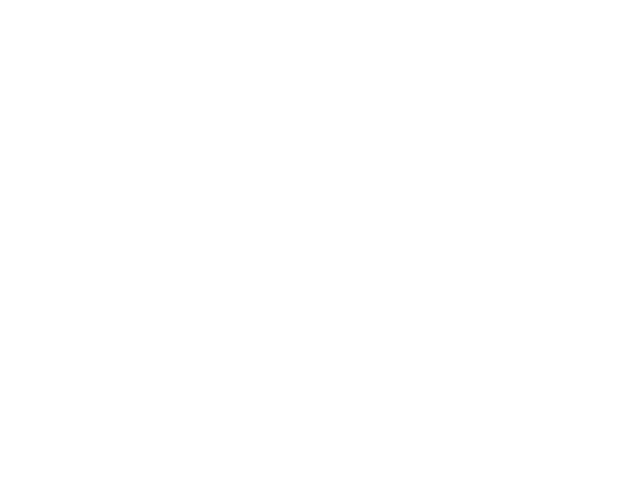

In [12]:
p.xlabel = "time (s)"
p.ylabel = "Fluorescence (a.u)"
fig = p.set_figure_flex("%d", "%d")#, figsize = p.figsize)
plt.plot(np.mean(time_list[idxs], axis = 0), np.mean(traces_list[idxs], axis = 0), color = "k", linewidth = 0.8)
p.save_name = "protocol/full_trace"
u = p.saving(fig)

p.xlabel = "time (s)"
p.ylabel = r"$F_m$ (a.u)"
fig = p.set_figure_flex("%d", "%d")#, figsize = p.figsize)
plt.plot(np.mean(time_list[idxs][:,250::20], axis = 0), np.mean(traces_list[idxs][:,250::20], axis = 0), color = "k", linewidth = 0.8)
p.save_name = "protocol/fm_trace"
u = p.saving(fig)

## mean traces

C:\Users\Alienor\AppData\Local\Temp\ipykernel_21812\3027527369.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  axs.append(plt.subplot(gs[0]))


1 95.29411764705881 % kept
2 90.36144578313254 % kept
367 93.01310043668121 % kept
0 97.82608695652173 % kept
162 96.12403100775194 % kept
182 94.8905109489051 % kept
198 94.6341463414634 % kept
365 92.67241379310344 % kept
6 93.33333333333333 % kept
7 95.4954954954955 % kept
120 95.23809523809523 % kept
121 96.5909090909091 % kept
168 97.36842105263158 % kept
169 93.79310344827586 % kept
188 93.85474860335195 % kept
189 96.5909090909091 % kept
204 95.8904109589041 % kept
205 93.07359307359307 % kept
14 96.73913043478261 % kept
15 96.045197740113 % kept
57 95.65217391304348 % kept
251 93.18181818181817 % kept
252 92.85714285714286 % kept
19 95.260663507109 % kept


g:\dream\from_github\alienlab\alienlab\plot.py:84: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  if type(f)==type(plt.figure()):


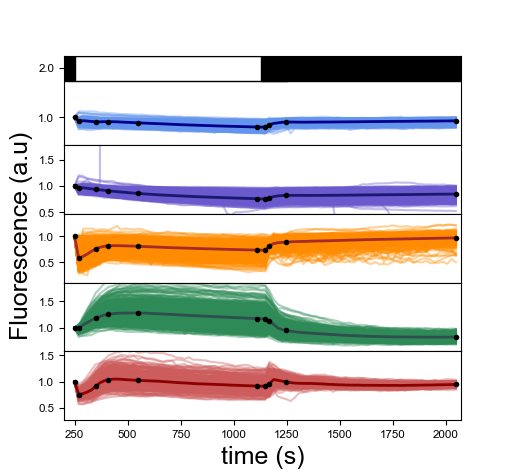

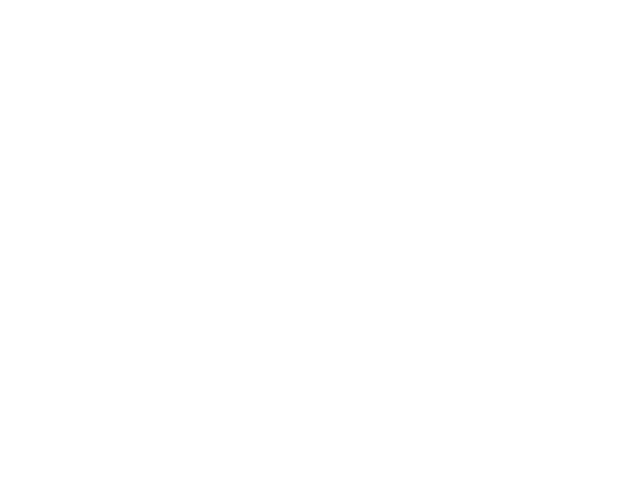

In [19]:
list_pair2 = np.array([250, 270, 350, 410, 550, 1110, 1150, 1170, 1250,2050])
list_pair2 = (list_pair2-250)//20


fig = p.set_figure_flex("%d", "%d")#, figsize = p.figsize)
fig.supylabel("Fluorescence (a.u)", fontsize = p.fontsize)
gs = gridspec.GridSpec(5, 1, height_ratios=[1.3, 1, 1, 1, 1]) 
axs = []

axs.append(plt.subplot(gs[0]))
axs[0].set_xlim(200, 2070)

axs.append(plt.subplot(gs[1], sharex = axs[0]))
axs.append(plt.subplot(gs[2], sharex = axs[0]))
axs.append(plt.subplot(gs[3], sharex = axs[0]))
axs.append(plt.subplot(gs[4], sharex = axs[0]))



for i, idx_set in enumerate([ blue, purple, orange, green, red]):
    idxs = define_idxs(idx_set, method)
    traces = pulses[idxs]
    M = np.mean(traces, axis=0)
    
    time = np.mean(time_pulses[idxs], axis = 0)
    plt.setp(axs[i].get_yticklabels(), fontsize = p.fonttick*0.7)
    plt.setp(axs[i].get_xticklabels(), fontsize = p.fonttick*0.7)
    axs[i].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    #axs[i].set_ylim(0.2, 2.2)
    axs[i].plot(time_pulses[idxs].T, (traces/traces[:,0:1]).T, alpha = 0.4,  color = ["cornflowerblue", "slateblue",  "darkorange", "seagreen", "indianred"][i])
    axs[i].plot(time, M/M[0],linewidth=2,  alpha = 1, color = [ "darkblue","midnightblue", "brown", "darkslategrey", "darkred"][i])
    axs[i].plot(time[list_pair2], M[list_pair2]/M[0],".k")
    if i==0:
        axs[i].set_ylim(np.mean(M[2]/M[0])-0.5, np.mean(M[2]/M[0])+0.8 + 0.5)
    else:
        axs[i].set_ylim(np.mean(M[2]/M[0])-0.5, np.mean(M[2]/M[0])+0.8)
    

axs[-1].set_xlabel("time (s)", fontsize=p.fontsize)    


plt.setp(axs[0].get_xticklabels(), visible=False)
plt.setp(axs[1].get_xticklabels(), visible=False)
plt.setp(axs[2].get_xticklabels(), visible=False)
plt.setp(axs[3].get_xticklabels(), visible=False)


plt.subplots_adjust(hspace=.0)
plt.subplots_adjust(wspace=.0)

lim = axs[0].get_ylim()[1] - 0.5
rectangles = {'black' : mpatch.Rectangle((0, lim), 250, 0.5, facecolor = "k", edgecolor = 'k'),
              'white' : mpatch.Rectangle((250,lim), 1000, 0.5, facecolor = "w", edgecolor = 'k'), 
             'black2' : mpatch.Rectangle((1130,lim), 1000, 0.5, facecolor = "k", edgecolor = 'k')}

for i, r in enumerate(rectangles):
    axs[0].add_artist(rectangles[r])
    rx, ry = rectangles[r].get_xy()
    cx = rx + rectangles[r].get_width()/2.0
    cy = ry + rectangles[r].get_height()/2.0

    #axs[0].annotate(r, (cx, cy), color=['w', 'k', 'w'][i], weight='bold', 
    #            fontsize=6, ha='center', va='center')
 
p.save_name = "protocol/strains"
u = p.saving(fig)

Text(0.5, 0, 'qI')

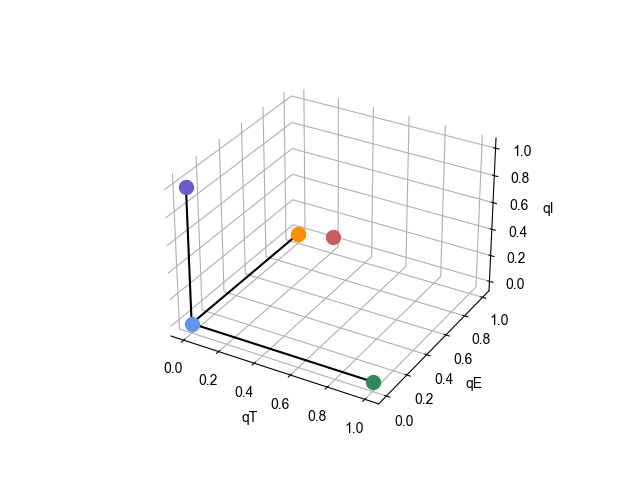

In [20]:
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')

ms = 100
ax.scatter3D(0,0,0, c="cornflowerblue", s = ms)
ax.scatter3D(0,0,1, c="slateblue", s = ms)
ax.scatter3D(0,1,0, c="darkorange", s = ms)
ax.scatter3D(1,0,0, c="seagreen", s = ms)
ax.scatter3D(0.5,0.5,0.5, c="indianred", s = ms)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.plot3D([0,0], [0,1], [0,0], "k")
ax.plot3D([0,0], [0,0], [0,1], "k")
ax.plot3D([0,1], [0,0], [0,0], "k")
ax.set_xlabel("qT")
ax.set_ylabel("qE")
ax.set_zlabel("qI")


#ax.view_init(30, 0)


color_condition = generate_col(10)
idxs = define_idxs(selected, method)
fig = create_fig(idxs, method, x, y, color_condition)

white_patch =  mpatches.Patch(color='white', label='photoinhibited  activated  STT7-1  WT4')

labeltick = r'         $\times$               $\times$          $\times$        $\times$    '

orange_patch = mpatches.Patch(color='darkorange', 
                              label= r'         $\times$                 $\times$              $\times$             ')
blue_patch = mpatches.Patch(color='cornflowerblue', 
                              label= r'         $\times$                                  $\times$    ')
green_patch = mpatches.Patch(color='seagreen', 
                              label= r'         $\times$                                              $\times$             ')
purple_patch = mpatches.Patch(color='slateblue', 
                              label= r'                                              $\times$             ')

plt.legend(handles=[white_patch, purple_patch, blue_patch, orange_patch, green_patch])


## image and traces

19 95.260663507109 % kept


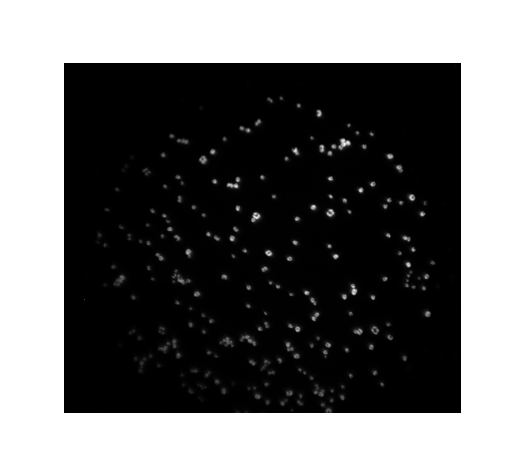

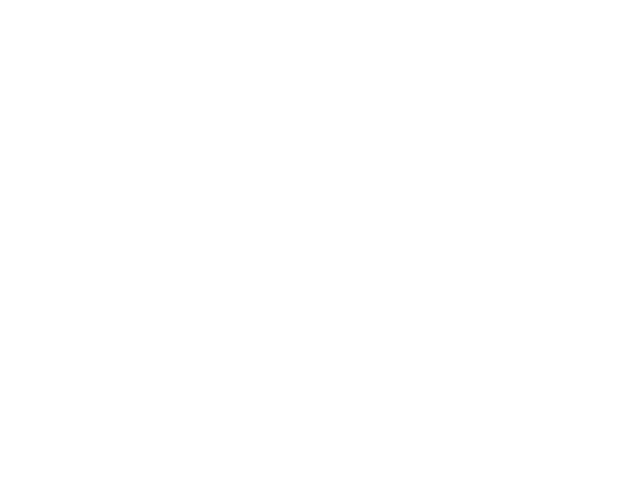

In [21]:
idx_image = red
idxs = define_idxs(idx_set, method)
image = imref_list[green[1]]
fig = p.set_figure_flex("%d", "%d")#, figsize=p.figsize)
plt.imshow(image[:, 100:-180], cmap = "Greys_r")  
plt.axis("off")
p.save_name = "protocol/algae"
u = p.saving(fig)

C:\Users\Alienor\AppData\Local\Temp\ipykernel_21812\2800718484.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  axs.append(plt.subplot(gs[0]))


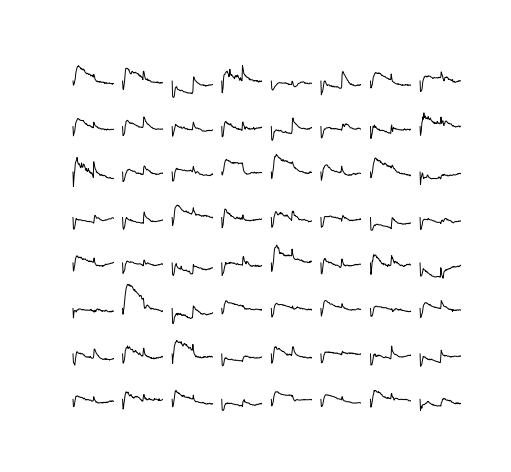

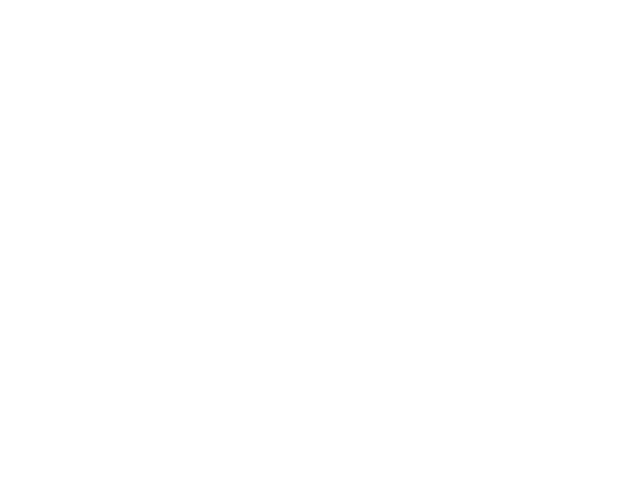

In [22]:
fig = p.set_figure_flex("%d", "%d")#, figsize = p.figsize)
N = 8
gs = gridspec.GridSpec(N, N, height_ratios=[1]*N) 
axs = []
axs.append(plt.subplot(gs[0]))
axs[0].set_xlim(-20, 90)
axs[0].set_ylim(0.5, 1.6)
traces = pulses[idxs]

for i in range(1, N*N):
    axs.append(plt.subplot(gs[i], sharex = axs[0], sharey = axs[0]))
    
for i in range(N*N):
    axs[i].plot(traces[i]/traces[i][0], 'k', linewidth=0.7)
    axs[i].axis('off')
    
plt.subplots_adjust(hspace=.0)
plt.subplots_adjust(wspace=.0)

p.save_name = "protocol/multiple_traces"
u = p.saving(fig)

C:\Users\Alienor\AppData\Local\Temp\ipykernel_21812\1462960698.py:26: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  axs.append(plt.subplot(gs[0]))


FOLDER_2022_03_16_WT222_SC1
39
39 94.6611909650924 % kept
39
39 94.6611909650924 % kept


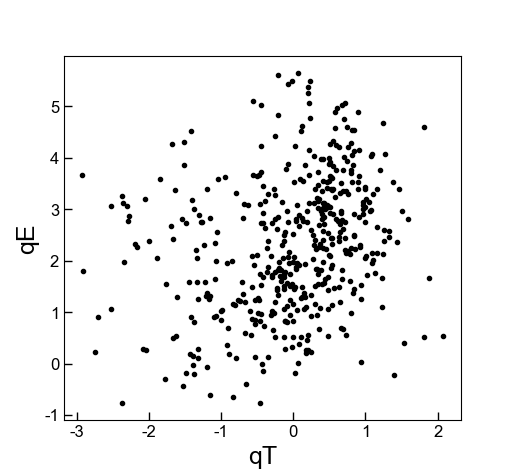

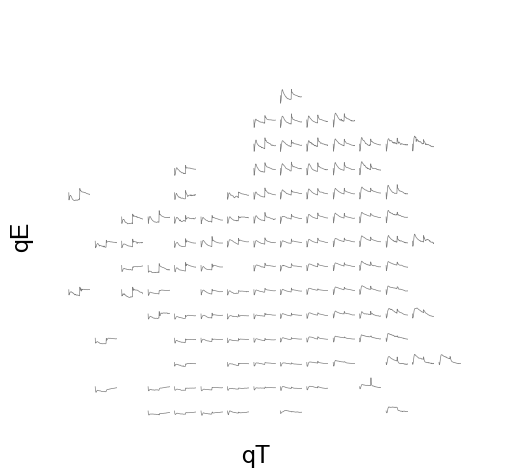

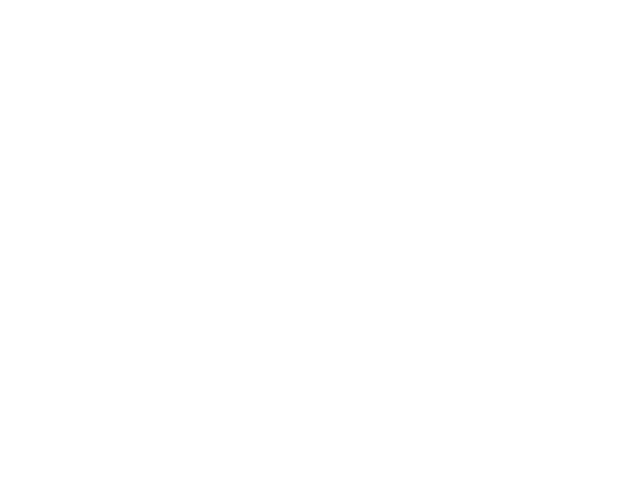

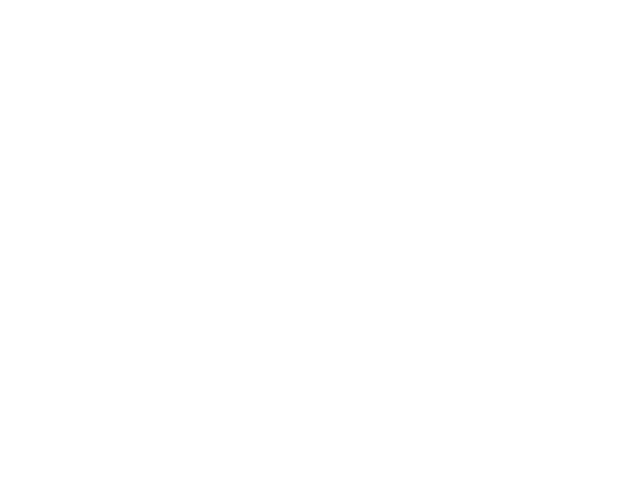

In [23]:
method = "combine2"
x, y=0,1
selected = [39]# wt4_activation#wt4_inhibition#wt4_activation


base = plt.cm.hot(np.linspace(0, 1, 12))


color_cond = ["k", base[2], base[2], base[5], base[5], base[7], base[7]]


p.xlabel =TEI[x]
p.ylabel = TEI[y]

fig1 = p.set_figure_flex("%d", "%d")#, figsize = p.figsize)
ax1 = plt.gca()
N = 15

fig2 = p.set_figure_flex("%d", "%d")#, figsize = p.figsize)
fig2.supxlabel(p.xlabel, fontsize = p.fontsize)
fig2.supylabel(p.ylabel, fontsize = p.fontsize)


gs = gridspec.GridSpec(N, N, height_ratios=[1]*N) 
axs = []
axs.append(plt.subplot(gs[0]))
axs[0].set_xlim(-20, 90)
axs[0].set_ylim(0.5, 1.8)
axs[0].set_ylim(0.4, 2)

for i in range(1, N*N):
    axs.append(plt.subplot(gs[i], sharex = axs[0], sharey = axs[0]))


for ni, id_set in enumerate(selected):#[orange, blue, green, red]):wt4_activation
    name_exp = class_match[str(id_set)]
    print(name_exp)
    print(id_set)
    idxs = define_idxs([id_set], method)

    X = Z[method][idxs][:,x]
    Y = Z[method][idxs][:,y]
    print(id_set)
    ax1.plot(X,Y, ".", color = color_cond[ni])

xlim = ax1.get_xlim()
ylim = ax1.get_ylim()

dx = xlim[1] - xlim[0]
dx = dx/N
dy = ylim[1] - ylim[0]
dy = dy/N

for ni, id_set in enumerate(selected):#[orange, blue, green, red]):
    
    idxs = define_idxs([id_set], method)
    X = Z[method][idxs][:,x]
    Y = Z[method][idxs][:,y]
    traces = pulses[idxs]

    means = []
    for i in range(N):
        xp = xlim[0] + i*dx
        for j in range(N):
            yp = ylim[1] - j*dy
            ind = (X>xp)*(X<xp+dx)*(Y>yp)*(Y<yp+dy)
            val = traces[ind]
            if len(val)>0:
                val = val/val[:,0:1]
                valo = np.mean(val, axis = 0)

                carac = np.mean(valo[1:40])/np.mean(valo[50:])
                
                axs[i + N*j].plot(valo, color =  color_cond[ni], alpha = 0.5, linewidth = 0.5)#(val.shape[0])**0.3)#["darkorange", "cornflowerblue", "seagreen", "indianred"][ni])#linewidth = carac**4)
            axs[j + N*i].axis('off')

    fig2.subplots_adjust(hspace=.0)
    fig2.subplots_adjust(wspace=.0)
    
    
p.save_name = "features/%s_points_%s_%s_"%(name_exp, TEI[x], TEI[y]) + method
u = p.saving(fig1)
p.save_name = "features/%s_traces_%s_%s_"%(name_exp, TEI[x], TEI[y]) +  method
u = p.saving(fig2)

## with table

0 94.56521739130434 % kept
1 94.11764705882352 % kept
2 93.97590361445783 % kept
6 95.23809523809523 % kept
7 96.3963963963964 % kept
14 96.73913043478261 % kept
15 95.48022598870057 % kept
57 95.65217391304348 % kept
120 90.47619047619048 % kept
121 92.04545454545455 % kept
162 96.12403100775194 % kept
168 94.07894736842105 % kept
169 95.86206896551724 % kept
182 94.16058394160584 % kept
188 93.29608938547486 % kept
189 94.31818181818183 % kept
198 95.60975609756098 % kept
204 96.34703196347031 % kept
205 95.23809523809523 % kept
251 95.45454545454545 % kept
252 92.85714285714286 % kept
365 98.70689655172413 % kept
367 93.01310043668121 % kept


KeyError: '0_0_1'

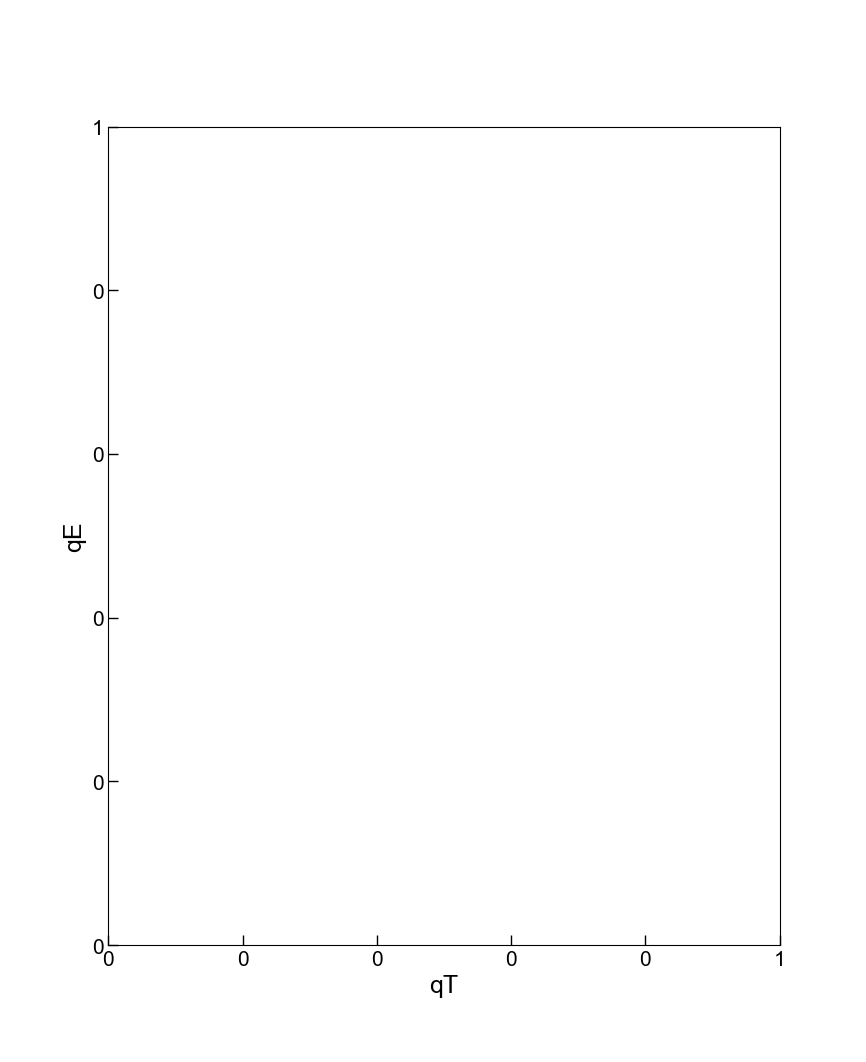

In [24]:

col_labels = ["marker", 'photoinhibited', 'activated', 'state transition', 'strain', "samples"]
marker = ""
ON = " "
OFF = " "
con = "white"
coff = "black"
table_vals = np.array([[marker, ON, ON, ON,  "STT7-1", len(blue)],
              [marker, ON, ON, ON,  "STT7-1", len(purple)],
              [marker, ON, ON, ON, "STT7-1", len(orange)],
              [marker, ON, ON, ON, "WT4",len(green)]])

cellcolors = np.array([
    [ "cornflowerblue",  coff, coff, coff, con, con],
    ["slateblue", con, coff, coff, con, con],
    ["darkorange", coff, con, coff, con, con],
    ["seagreen",  coff, coff,  con, con, con]
])

selected_qE_qT = purple + blue + orange + green
method = "combine3"
x,y = 0,1

color_condition = generate_col(10)
p.fontsize = 18
p.fonttick = 15
idxs_qE_qT = define_idxs(selected_qE_qT, method)
fig = p.set_figure_flex("%d", "%d", figsize = (22, 27))
fig = create_fig(idxs_qE_qT, method, x, y, color_condition, fig, markersize=12)


# Add a table at the bottom of the axes
the_table = plt.table(cellText=table_vals,
                      rowLabels=None,
                      colLabels=col_labels,
                      loc='top', 
                      cellColours = cellcolors)          

cells = the_table.properties()["celld"]
for j in range(0, len(col_labels)):
    for i in range(0, table_vals.shape[0]+1):
        cells[i, j].set_text_props(ha="center", va='center_baseline')
        
the_table.auto_set_font_size(False)
the_table.set_fontsize(12)
the_table.scale(1,1.3)

p.save_name = "features/project_table_%s_%s_%s"%(TEI[x], TEI[y], method)
u = p.saving(fig)

KeyError: '0_0_1'

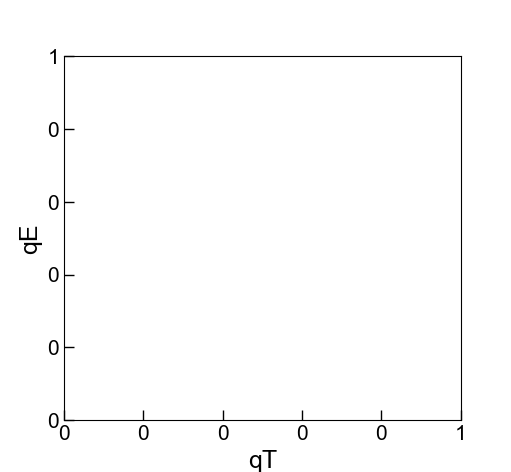

In [25]:
from matplotlib.patches import Rectangle
fig1 = p.set_figure_flex("%d", "%d")#, figsize = p.figsize)
method = "combine2"

x,y = 0,1
fig1 = create_fig(idxs_qE_qT, method, x, y, color_condition, fig1)


ax = plt.gca()
#add rectangle to plot
qE_val = [-3, 1, 2, 2]
qR_val = [-2.5, -1.5, 2, 1]
qT_val = [2, -2, 2, 2]

ax.add_patch(Rectangle((qE_val[0], qE_val[1]), qE_val[2], qE_val[3],
             edgecolor = 'darkorange',
             facecolor = 'moccasin',
             fill=True,
             lw=3, 
             alpha = 0.5))

ax.add_patch(Rectangle((qR_val[0], qR_val[1]), qR_val[2], qR_val[3],
             edgecolor = 'cornflowerblue',
             facecolor = 'lightblue',
             fill=True,
             lw=3, 
             alpha = 0.5))

ax.add_patch(Rectangle((qT_val[0], qT_val[1]), qT_val[2], qT_val[3],
             edgecolor = 'seagreen',
             facecolor = 'lightgreen',
             fill=True,
             lw=3, 
             alpha = 0.5))
             
    
p.save_name = "features/squares_%s_%s_%s"%(TEI[x], TEI[y], method)
u = p.saving(fig1)
    

x,y = 1,2
fig2 = p.set_figure_flex("%d", "%d")#, figsize = p.figsize)
fig2 = create_fig(idxs_qE_qT, method, x, y, color_condition, fig2)

ax = plt.gca()
#add rectangle to plot
qI_val = [-1.5, 2, 0.7, 2]


ax.add_patch(Rectangle((qI_val[0], qI_val[1]), qI_val[2], qI_val[3],
             edgecolor = 'slateblue',
             facecolor = 'lavender',
             fill=True,
             lw=3, 
             alpha = 0.5))
p.save_name = "features/squares_%s_%s_%s"%(TEI[x], TEI[y], method)
u = p.saving(fig2)


x,y = 0,2
fig3 = p.set_figure_flex("%d", "%d")#, figsize = p.figsize)
fig3 = create_fig(idxs_qE_qT, method, x, y, color_condition, fig3)
p.save_name = "features/squares_%s_%s_%s"%(TEI[x], TEI[y], method)
u = p.saving(fig3)

C:\Users\Alienor\AppData\Local\Temp\ipykernel_19040\1219706151.py:33: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  axs.append(plt.subplot(gs[0]))


False
True
True
True


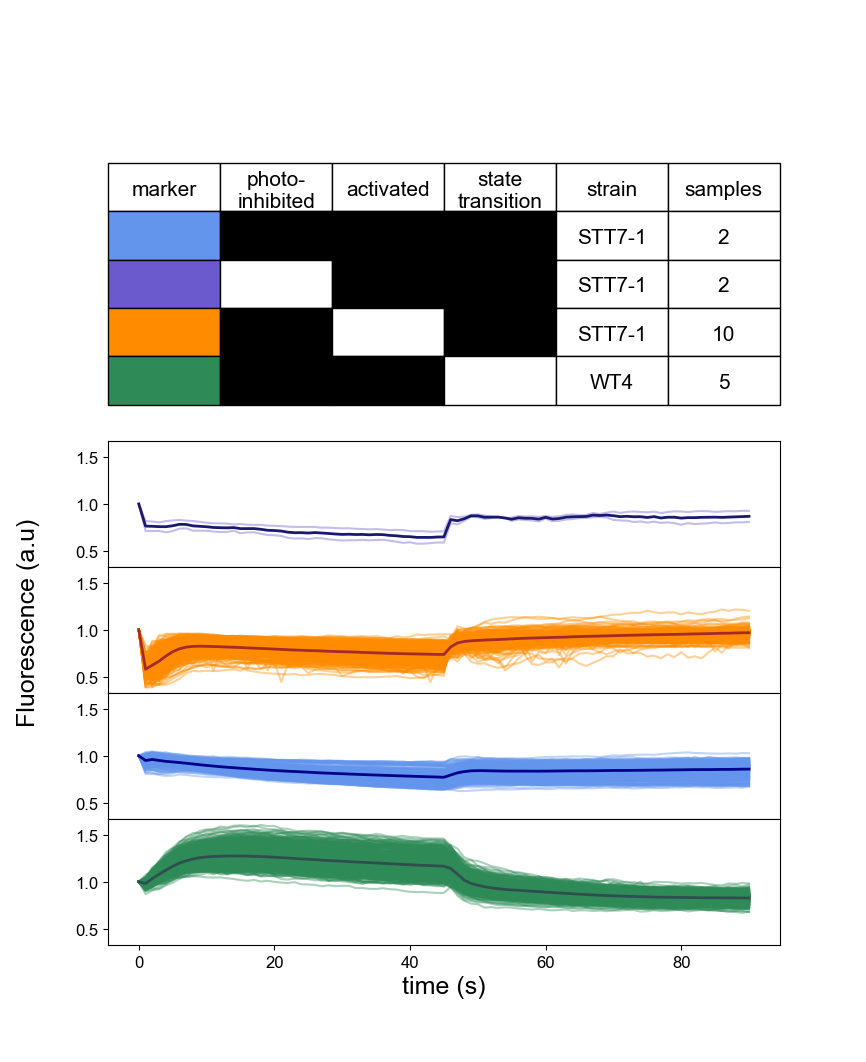

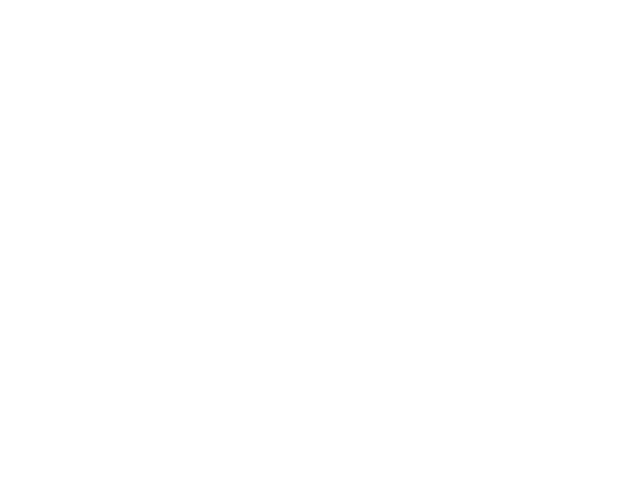

In [100]:

col_labels = ["marker", 'photo-\ninhibited', 'activated', 'state\ntransition', 'strain', "samples"]
marker = ""
ON = " "
OFF = " "
con = "white"
coff = "black"
table_vals = np.array([[marker, ON, ON, ON,  "STT7-1", len(blue)],
              [marker, ON, ON, ON,  "STT7-1", len(purple)],
              [marker, ON, ON, ON, "STT7-1", len(orange)],
              [marker, ON, ON, ON, "WT4",len(green)]])

cellcolors = np.array([
    [ "cornflowerblue",  coff, coff, coff, con, con],
    ["slateblue", con, coff, coff, con, con],
    ["darkorange", coff, con, coff, con, con],
    ["seagreen",  coff, coff,  con, con, con]
])

selected_qE_qT = purple + blue + orange + green
method = "combine1"
x,y = 0,1

color_condition = generate_col(10)
p.fontsize = 18
p.fonttick = 15

fig = p.set_figure_flex("%d", "%d", figsize = (22, 27))
gs = gridspec.GridSpec(5, 1, height_ratios=[2.5, 1, 1, 1, 1]) 
axs = []
axs = []


axs.append(plt.subplot(gs[0]))
axs.append(plt.subplot(gs[1]))
#axs[1].set_xlim(-2, 95)
#axs[1].set_ylim(0.5, 1.3)
axs.append(plt.subplot(gs[2], sharey = axs[1]))
axs.append(plt.subplot(gs[3], sharey = axs[2]))
axs.append(plt.subplot(gs[4], sharey = axs[3]))



axs.append(plt.subplot(gs[1]))

# Add a table at the bottom of the axes

#axs[0].axis('tight')
axs[0].axis('off')
the_table = axs[0].table(cellText=table_vals,
                      rowLabels=None,
                      colLabels=col_labels,
                      loc='center', 
                      cellColours = cellcolors)          

cells = the_table.properties()["celld"]
for j in range(0, len(col_labels)):
    for i in range(0, table_vals.shape[0]+1):
        cells[i, j].set_text_props(ha="center", va='center_baseline')
        
the_table.auto_set_font_size(False)
the_table.set_fontsize(15)
the_table.scale(1,2.5)

#p.save_name = "features/project_table_%s_%s_%s"%(TEI[x], TEI[y], method)
#u = p.saving(fig)


p.fonttick = 12
p.figsize=(10, 10)

pulses0 = pulses[idxs_qE_qT]
Z0 = Z[method][idxs_qE_qT]
label_list0 = label_list[idxs_qE_qT]
id_list0 = id_list[idxs_qE_qT]
algae_list0 = algae_list[idxs_qE_qT]



           

for i, rectangle in enumerate([qI_val, qE_val, qR_val, qT_val]):
    print(rectangle!= qI_val)
    if rectangle != qI_val: 
        x,y = 0,1
    else:
        x,y = 1,2
        
    left = Z0[:,x] > rectangle[0]
    right =  Z0[:,x] < rectangle[0] + rectangle[2]
    bottom = Z0[:,y] > rectangle[1]
    top =  Z0[:,y] < rectangle[1] + rectangle[3]
    
    limits = left*right*bottom*top
    
    traces = pulses0[limits]
    traces /= traces[:,0:1]
    
    axs[i+1].plot(traces.T, alpha = 0.4,  color = ["slateblue", "darkorange", "cornflowerblue", "seagreen"][i])
    axs[i+1].plot(np.mean(traces, axis = 0), linewidth=2,  alpha = 1, color = ["midnightblue", "brown", "darkblue", "darkslategrey"][i])
    plt.setp(axs[i+1].get_yticklabels(), fontsize = p.fonttick)
    
    
plt.setp(axs[0].get_xticklabels(), visible=False)
plt.setp(axs[1].get_xticklabels(), visible=False)
plt.setp(axs[2].get_xticklabels(), visible=False)
plt.setp(axs[3].get_xticklabels(), visible=False)
plt.setp(axs[4].get_xticklabels(), fontsize = p.fonttick)

plt.subplots_adjust(hspace=.0)
fig.supylabel("Fluorescence (a.u)                          ", fontsize = p.fontsize)

axs[4].set_xlabel("time (s)", fontsize = p.fontsize)

p.save_name = "features/inside_square_traces_%s_%s_%s"%(TEI[x], TEI[y], method)
u = p.saving(fig)

C:\Users\Alienor\AppData\Local\Temp\ipykernel_22756\3301785609.py:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  axs.append(plt.subplot(gs[0]))


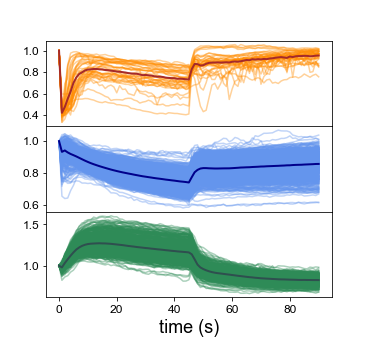

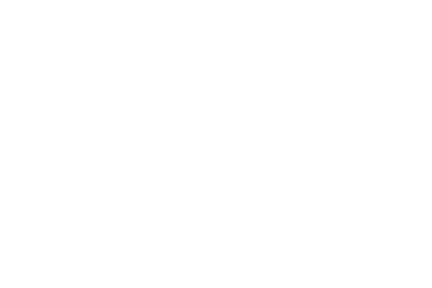

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2 90.36144578313254 % kept
3 92.7710843373494 % kept
14 95.65217391304348 % kept
15 96.61016949152543 % kept
57 96.08695652173913 % kept
251 93.18181818181817 % kept
252 90.47619047619048 % kept
6 92.38095238095238 % kept
7 95.4954954954955 % kept
120 95.23809523809523 % kept
121 96.5909090909091 % kept
168 95.39473684210526 % kept
169 93.79310344827586 % kept
188 93.29608938547486 % kept
189 96.5909090909091 % kept
204 95.4337899543379 % kept
205 93.5064935064935 % kept
0 97.82608695652173 % kept
162 94.57364341085271 % kept
182 94.8905109489051 % kept
198 94.6341463414634 % kept
12 96.37305699481865 % kept
13 95.78947368421052 % kept
14 95.65217391304348 % kept
15 96.61016949152543 % kept


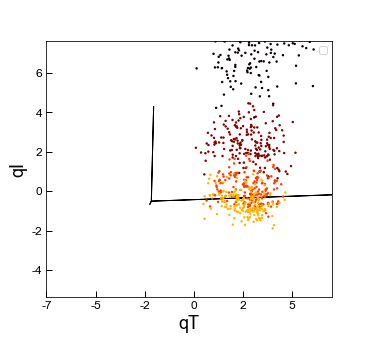

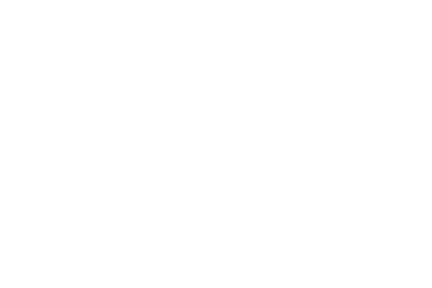

In [72]:

def plot_axis(method, x, y, blue, green, orange, purple):
    #fig = create_fig(idxs_qE_qT, method, x, y, color_condition)
    fig = p.set_figure_flex("%d", "%d")#, figsize = p.figsize)

    idxs_blue = define_idxs(blue, method)
    Z_blue = np.mean(Z[method][idxs_blue], axis = 0)
    #plt.scatter(Z_blue[x], Z_blue[y], c ='k')

    idxs_green = define_idxs(green, method)
    Z_green = np.mean(Z[method][idxs_green], axis = 0)
    #plt.scatter(Z_green[x], Z_green[y], c ='k')

    idxs_orange = define_idxs(orange, method)
    Z_orange = np.mean(Z[method][idxs_orange], axis = 0)
    #plt.scatter(Z_orange[x], Z_orange[y], c ='k')

    idxs_purple = define_idxs(purple, method)
    Z_purple = np.mean(Z[method][idxs_purple], axis = 0)
    #plt.scatter(Z_purple[x], Z_purple[y], c ='k')
    
    origin = np.array([Z_blue[x], Z_blue[y]])
    qE = 2*np.array([Z_orange[x]- Z_blue[x], Z_orange[y]- Z_blue[y]])
    qT = 2*np.array([Z_green[x]- Z_blue[x], Z_green[y]- Z_blue[y]])
    qI = 2*np.array([Z_purple[x]- Z_blue[x], Z_purple[y]- Z_blue[y]])
    
    plt.arrow(origin[0], origin[1], qE[0], qE[1])
    plt.arrow(origin[0], origin[1], qT[0], qT[1])
    plt.arrow(origin[0], origin[1], qI[0], qI[1])
    
    plt.xlim(lims[method]["%d,%d"%(x,y)][0])
    plt.ylim(lims[method]["%d,%d"%(x,y)][1])

    lbl = TEI
    plt.xlabel(lbl[x])
    plt.ylabel(lbl[y])
    return fig

method = "combine0"
x = 0
y = 2
fig = plot_axis(method, x, y, blue, green, orange, purple)
selected = wt4_inhibition2
idxs_activation = define_idxs(selected, method)
base = plt.cm.hot(np.linspace(0, 1, 12))

color_cond = {'1_0_2': np.array([base[0]]*10),
              '1_1_2': np.array([base[2]]*10),
              '1_1_3': np.array([base[2]]*10),
              '1_2_2': np.array([base[5]]*10),
              '1_2_3': np.array([base[5]]*10),
              '1_3_2': np.array([base[7]]*10),
              '1_3_3': np.array([base[7]]*10),
             
              '2_0_3': np.array([base[0]]*10),
             '2_0_2': np.array([base[0]]*10),
              '2_1_2': np.array([base[2]]*10),
              '2_1_3': np.array([base[2]]*10),
              '2_2_2': np.array([base[5]]*10),
              '2_2_3': np.array([base[5]]*10),
              '2_3_2': np.array([base[7]]*10),
              '2_3_3': np.array([base[7]]*10),
             
             '1_0_0': np.array([base[0]]*10),
              '1_0_1': np.array([base[2]]*10),
              '1_0_2': np.array([base[5]]*10),
              '1_0_3': np.array([base[7]]*10),}

exp_name = class_match[str(selected[0])]
create_fig(idxs_activation, method, x, y, color_cond, fig)
p.save_name = "features/evolution_%s_%s_%s_%s"%(exp_name, TEI[x], TEI[y], method)
u = p.saving(fig)

0 97.82608695652173 % kept
2 90.36144578313254 % kept
3 92.7710843373494 % kept
6 92.38095238095238 % kept
7 95.4954954954955 % kept
12 96.37305699481865 % kept
14 95.65217391304348 % kept
15 96.61016949152543 % kept
55 95.87628865979381 % kept
57 96.08695652173913 % kept
120 95.23809523809523 % kept
121 96.5909090909091 % kept
162 94.57364341085271 % kept
168 95.39473684210526 % kept
169 93.79310344827586 % kept
182 94.8905109489051 % kept
188 93.29608938547486 % kept
189 96.5909090909091 % kept
198 94.6341463414634 % kept
204 95.4337899543379 % kept
205 93.5064935064935 % kept
249 95.83333333333334 % kept
251 93.18181818181817 % kept
252 90.47619047619048 % kept


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


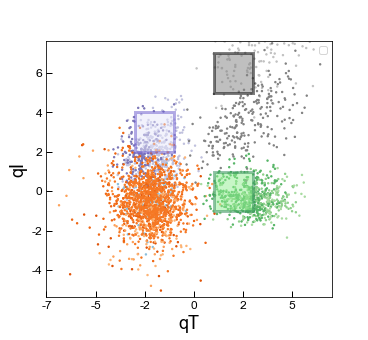

In [74]:
from matplotlib.patches import Rectangle

x,y = 0,2
fig = p.set_figure_flex("%d", "%d")#, figsize = p.figsize)
fig = create_fig(idxs_qI_qT, method, x, y, color_condition, fig)

ax = plt.gca()
#add rectangle to plot
qI_val = [-3, 2, 2, 2]
qIqT_val = [1, 5, 2, 2]
qR_val2 = [1, -1, 2, 2]


ax.add_patch(Rectangle((qI_val[0], qI_val[1]), qI_val[2], qI_val[3],
             edgecolor = 'slateblue',
             facecolor = 'lavender',
             fill=True,
             lw=3, 
             alpha = 0.5))

ax.add_patch(Rectangle((qIqT_val[0], qIqT_val[1]), qIqT_val[2], qIqT_val[3],
             edgecolor = 'black',
             facecolor = 'grey',
             fill=True,
             lw=3, 
             alpha = 0.5))

ax.add_patch(Rectangle((qR_val2[0], qR_val2[1]), qR_val2[2], qR_val2[3],
             edgecolor = 'seagreen',
             facecolor = 'lightgreen',
             fill=True,
             lw=3, 
             alpha = 0.5))




C:\Users\Alienor\AppData\Local\Temp\ipykernel_22756\1792120175.py:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  axs.append(plt.subplot(gs[0]))


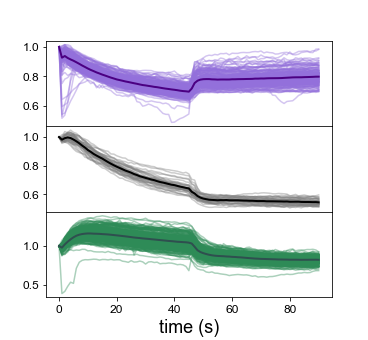

In [75]:
from matplotlib import gridspec


p.figsize=(10, 10)
fig = p.set_figure_flex("%d", "%d")#, figsize = p.figsize)
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1]) 

pulses0 = pulses[idxs_qI_qT]
Z0 = Z[method][idxs_qI_qT]
label_list0 = label_list[idxs_qI_qT]
id_list0 = id_list[idxs_qI_qT]
algae_list0 = algae_list[idxs_qI_qT]

x,y = 0,2
axs = []
axs.append(plt.subplot(gs[0]))
axs.append(plt.subplot(gs[1], sharex = axs[0]))
axs.append(plt.subplot(gs[2], sharex = axs[0]))

   
for i, rectangle in enumerate([qI_val, qIqT_val, qR_val2]):
    
    left = Z0[:,x] > rectangle[0]
    right =  Z0[:,x] < rectangle[0] + rectangle[2]
    bottom = Z0[:,y] > rectangle[1]
    top =  Z0[:,y] < rectangle[1] + rectangle[3]
    
    limits = left*right*bottom*top
    
    traces = pulses0[limits]
    traces /= traces[:,0:1]
    axs[i].plot(traces.T, alpha = 0.4,  color = ["mediumpurple", "grey", "seagreen"][i])
    axs[i].plot(np.mean(traces, axis = 0), linewidth=2,  alpha = 1, color = ["indigo", "black", "darkslategrey"][i])
    plt.setp(axs[i].get_yticklabels(), fontsize = p.fonttick)
    
plt.setp(axs[0].get_xticklabels(), visible=False)
plt.setp(axs[1].get_xticklabels(), visible=False)
plt.setp(axs[2].get_xticklabels(), fontsize = p.fonttick)

axs[2].set_xlabel("time (s)", fontsize = p.fontsize)
plt.subplots_adjust(hspace=.0)

## Linearity

0 95.65217391304348 % kept
182 94.8905109489051 % kept


C:\Users\Alienor\AppData\Local\Temp\ipykernel_2232\1992694434.py:5: RuntimeWarning: divide by zero encountered in true_divide
  P = pulses/pulses[:,-1:]
C:\Users\Alienor\AppData\Local\Temp\ipykernel_2232\1992694434.py:5: RuntimeWarning: invalid value encountered in true_divide
  P = pulses/pulses[:,-1:]


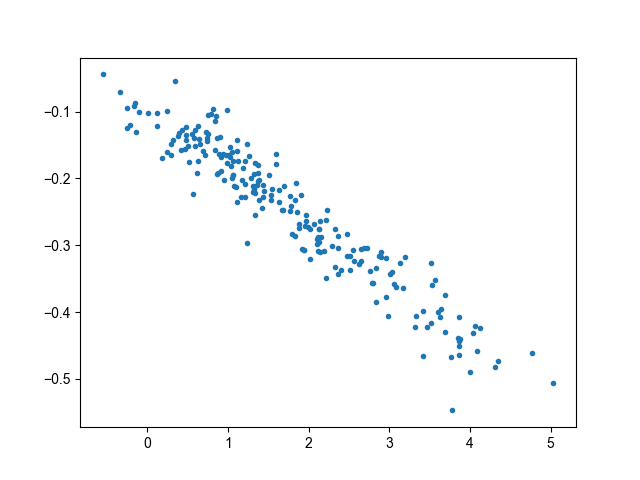

In [60]:
selected = purple

idxs_qI = define_idxs(selected, method)
plt.figure()
P = pulses/pulses[:,-1:]

plt.plot(Z[method][idxs_qI,2], P[idxs_qI,-1]-P[idxs_qI,0], ".")





6 95.23809523809523 % kept
7 91.8918918918919 % kept
120 91.66666666666666 % kept
121 92.04545454545455 % kept
168 95.39473684210526 % kept
169 95.17241379310344 % kept
188 93.85474860335195 % kept
189 93.18181818181817 % kept
204 95.4337899543379 % kept
205 96.96969696969697 % kept


C:\Users\Alienor\AppData\Local\Temp\ipykernel_2232\533293477.py:3: RuntimeWarning: divide by zero encountered in true_divide
  P = pulses/pulses[:,0:1]
C:\Users\Alienor\AppData\Local\Temp\ipykernel_2232\533293477.py:3: RuntimeWarning: invalid value encountered in true_divide
  P = pulses/pulses[:,0:1]


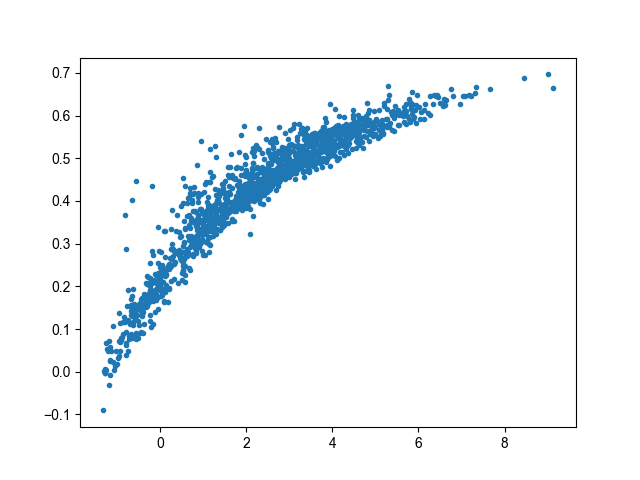

In [43]:
idxs_qI = define_idxs(orange, method)
plt.figure()
P = pulses/pulses[:,0:1]
plt.plot(Z[method][idxs_qI,1], P[idxs_qI,0]-P[idxs_qI,1], ".")

14 95.1086956521739 % kept
15 96.045197740113 % kept
57 96.52173913043478 % kept
251 95.45454545454545 % kept
252 95.23809523809523 % kept


C:\Users\Alienor\AppData\Local\Temp\ipykernel_2232\2496734373.py:3: RuntimeWarning: divide by zero encountered in true_divide
  P = pulses/pulses[:,0:1]
C:\Users\Alienor\AppData\Local\Temp\ipykernel_2232\2496734373.py:3: RuntimeWarning: invalid value encountered in true_divide
  P = pulses/pulses[:,0:1]


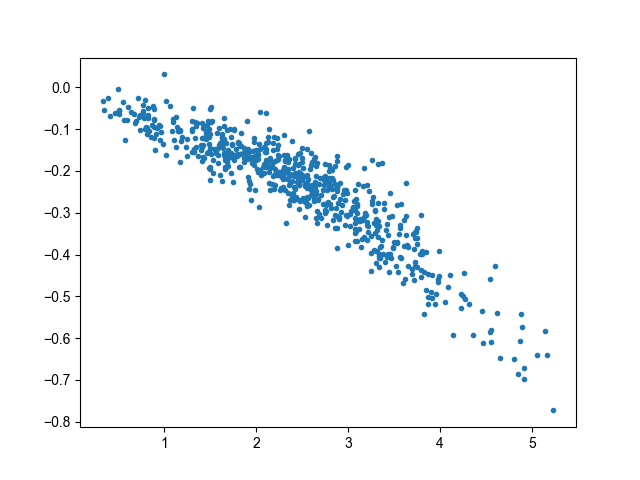

In [59]:
idxs_qI = define_idxs(green, method)
plt.figure()
P = pulses/pulses[:,0:1]
plt.plot(Z[method][idxs_qI,0], P[idxs_qI,0]-P[idxs_qI,8], ".")

In [56]:
(1170-250)/20

46.0

In [ ]:
250/20